In [1]:
!pip install -r 'requirements.txt'

ERROR: Could not open requirements file: [Errno 2] No such file or directory: "'requirements1.txt'"
You should consider upgrading via the 'C:\Users\irink\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
# Importing libraries
import cv2
import os
import pandas as pd
import random
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
#from pydub import AudioSegment
import re
from moviepy.editor import *
from collections import Counter
import plotly.express as px
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D, AveragePooling2D, Add)
from tensorflow.keras.layers import (Activation, GlobalAveragePooling2D, Reshape, Multiply, LSTM, Bidirectional, MaxPooling2D, Input)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
import visualkeras
from PIL import ImageFont
from keras.callbacks import LearningRateScheduler
import math
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
import csv
import scipy
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2, l1_l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from tensorflow.keras.models import load_model
import joblib
#import zip

In [3]:
data = pd.read_csv('Files_for_program/data_multiple_parameters_tess_ravdess_savee.csv')

In [4]:
y = data.iloc[:, -2]

X = np.array(data.iloc[:, 1:-3], dtype = float)

x_tr, x_va, y_tr, y_va = train_test_split(X,y,train_size=0.75,shuffle=True,random_state=12345)
x_va, x_te, y_va, y_te = train_test_split(x_va,y_va,train_size=0.7,shuffle=True,random_state=12345)

scaler = StandardScaler()
encoder = LabelEncoder()

x_tr = scaler.fit_transform(x_tr)
y_tr = encoder.fit_transform(y_tr)

x_va = scaler.transform(x_va)
y_va = encoder.transform(y_va)

x_te = scaler.transform(x_te)
y_te = encoder.transform(y_te)

In [5]:
# сохранение scaler
joblib.dump(scaler, 'scaler1.pkl')

# сохранение encoder
joblib.dump(encoder, 'encoder1.pkl')

['encoder.pkl']

In [6]:
print('Обучающая выборка: ', x_tr.shape)
print('Валидационная выборка: ', x_va.shape)
print('Тестовая выборка: ', x_te.shape)

Обучающая выборка:  (3540, 40)
Валидационная выборка:  (826, 40)
Тестовая выборка:  (354, 40)


In [8]:
folder_path = 'Experiments/'

def get_number_experiment(name):
    count = 0
    for f in os.scandir(folder_path):
        name_exp = f.path.split('Experiments/')[1].split('_')[0]
        if name_exp == name:
            count += 1
    return count
    
def path_for_best_model(name,i):
    file_path = f'{folder_path}{name}_{i}/'
    if path_exists_and_make(file_path):
        return file_path

def path_exists_and_make(file_path):
    if not os.path.exists(file_path): 
        os.makedirs(file_path)
    return True

def save_model(model,name,i,bs,e):
    file_path = f'{folder_path}{name}_{i}/'
    if path_exists_and_make(file_path): 
        model.save(f'{file_path}model_bs{bs}_e{e}.h5')
        model.save_weights(f'{file_path}weights.h5')

def save_layerkeras(model,name,i):
    filepath_pc = f'{folder_path}{name}_{i}/'
    print(filepath_pc)
    if path_exists_and_make(filepath_pc): 
        model_layers = visualkeras.layered_view(model,legend = True, to_file=f'{filepath_pc}model_layers.png')
        return model_layers

def plot_hist(history, name, i):
    # Plots neural network performance metrics for train and validation
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    plt.suptitle(f'{name}_experiment{i}', size=15)
    results = pd.DataFrame(history.history)
    results[["loss", "val_loss"]].plot(ax=axs[0])
    axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
    results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
    axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
    
    file_path = f'{folder_path}{name}_{i}/'
    if path_exists_and_make(file_path):
        plt.savefig(f'{file_path}result.jpg')
        
    return plt.show()

def plot_confusion_matrices(y_true, y_pred, name, i):

    labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    file_path = f'{folder_path}{name}_{i}/'
    if path_exists_and_make(file_path):
        plt.savefig(f'{file_path}confusion_matrix.jpg')

    return plt.show()

### 1. CNN-ENG

In [10]:
name_model = "CNN-MP-ENG-tess-ravdess-savee"
num_exp = int(get_number_experiment(name_model))
num_exp

0

In [11]:
model = keras.Sequential()

model.add(Conv1D(128, 5, activation='relu',padding="same", input_shape=(x_tr.shape[1],1)))
model.add(Dropout(0.1))

model.add(Conv1D(128, 4, activation='relu',padding="same"))
model.add(Dropout(0.3))

model.add(BatchNormalization()) 

model.add(Conv1D(64, 4, activation='relu',padding="same"))
model.add(Dropout(0.5)) 

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=L2(0.02)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1)) 

model.add(Dense(7, activation='softmax'))
model.compile(optimizer=SGD(lr=0.01, clipnorm=1.,decay=1e-6, nesterov=True), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 128)           768       
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           65664     
                                                                 
 dropout_1 (Dropout)         (None, 40, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 40, 128)          512       
 ormalization)                                                   
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 64)            32832     
                                                        

### Обучение

In [12]:
checkpoint = ModelCheckpoint(filepath=f'{path_for_best_model(name_model,num_exp+1)}best_model_cnn_mp_en.h5',
                             save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [13]:
batch_size = 16
epochs = 1000

history = model.fit (
    x_tr,
    y_tr,
    batch_size,
    epochs,
    validation_data=(x_va, y_va),
    callbacks=[checkpoint,early_stop]
    )

num_exp += 1

Epoch 1/1000
222/222 [==============================] - 46s 170ms/step - loss: 11.3366 - accuracy: 0.1525 - val_loss: 11.0444 - val_accuracy: 0.1719
Epoch 2/1000
222/222 [==============================] - 29s 131ms/step - loss: 10.9448 - accuracy: 0.1650 - val_loss: 10.7698 - val_accuracy: 0.1731
Epoch 3/1000
222/222 [==============================] - 27s 122ms/step - loss: 10.6382 - accuracy: 0.1661 - val_loss: 10.4584 - val_accuracy: 0.2022
Epoch 4/1000
222/222 [==============================] - 26s 118ms/step - loss: 10.3015 - accuracy: 0.1963 - val_loss: 10.1123 - val_accuracy: 0.2688
Epoch 5/1000
222/222 [==============================] - 26s 117ms/step - loss: 9.9625 - accuracy: 0.2260 - val_loss: 9.7690 - val_accuracy: 0.2579
Epoch 6/1000
222/222 [==============================] - 26s 117ms/step - loss: 9.6398 - accuracy: 0.2432 - val_loss: 9.4351 - val_accuracy: 0.3087
Epoch 7/1000
222/222 [==============================] - 26s 117ms/step - loss: 9.3402 - accuracy: 0.2638 - val

In [14]:
save_model(model, name_model, num_exp,batch_size,epochs)

In [17]:
!pip uninstall visualkeras
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

^C


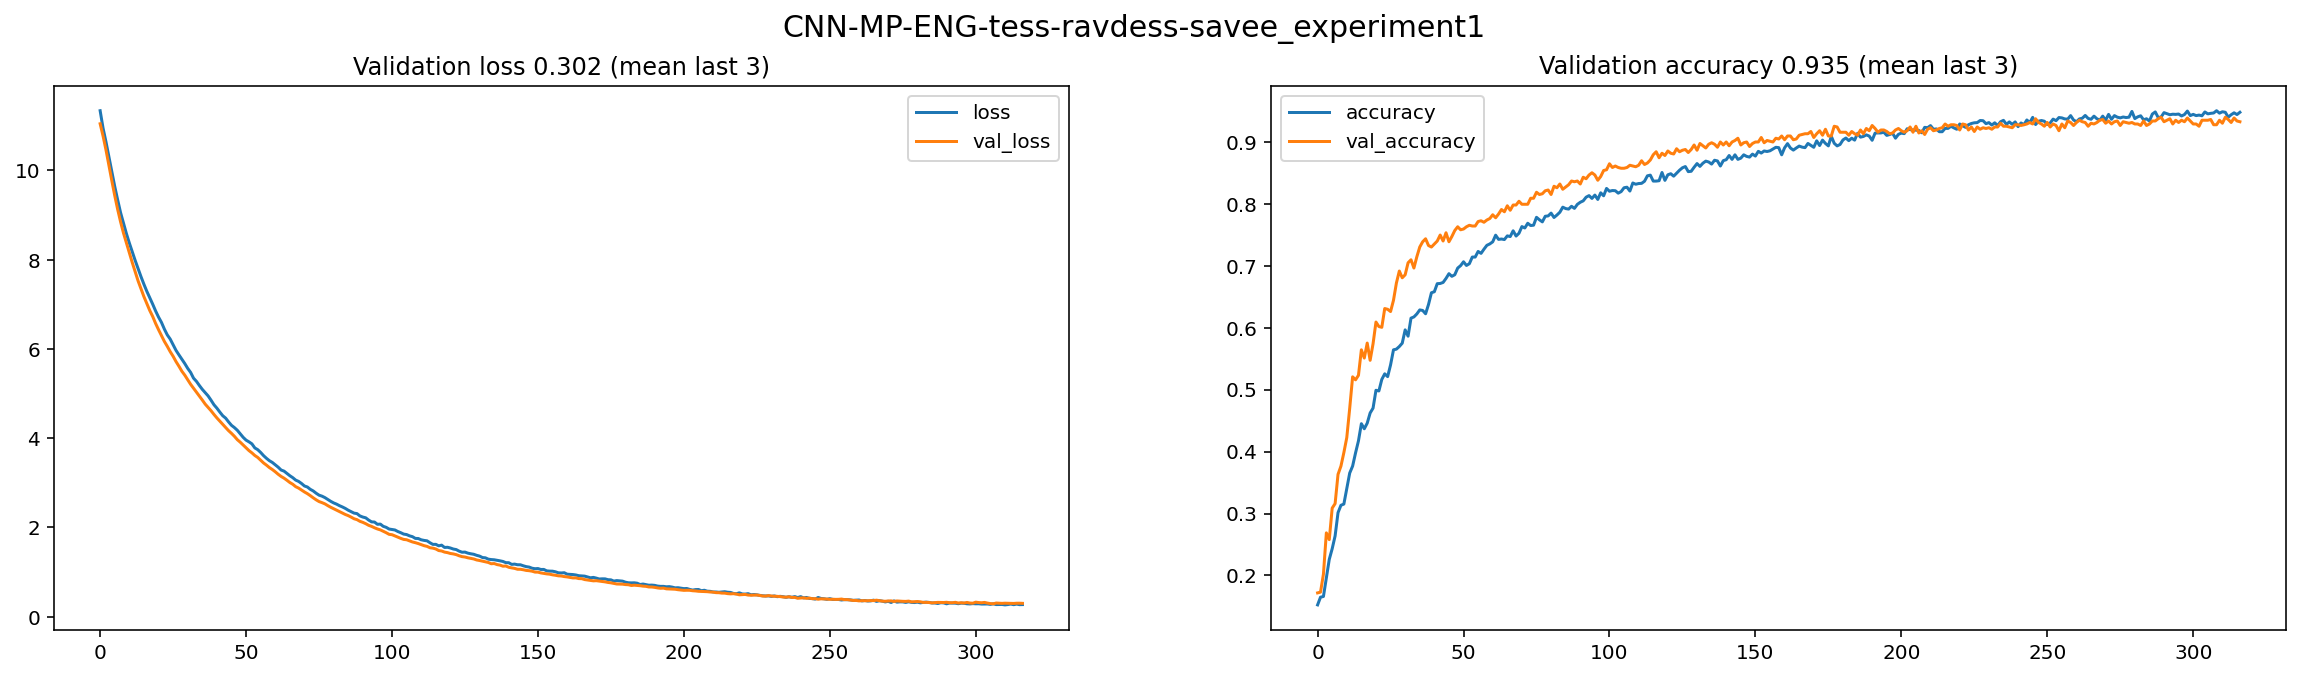

In [15]:
plot_hist(history, name_model, num_exp)

In [ ]:
save_layerkeras(model, name_model, num_exp)

### Тест

In [ ]:
# calculate accuracy
test_loss, test_acc = model.evaluate(x_te,y_te)
print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(100 * test_acc))

12/12 [==============================] - 0s 3ms/step


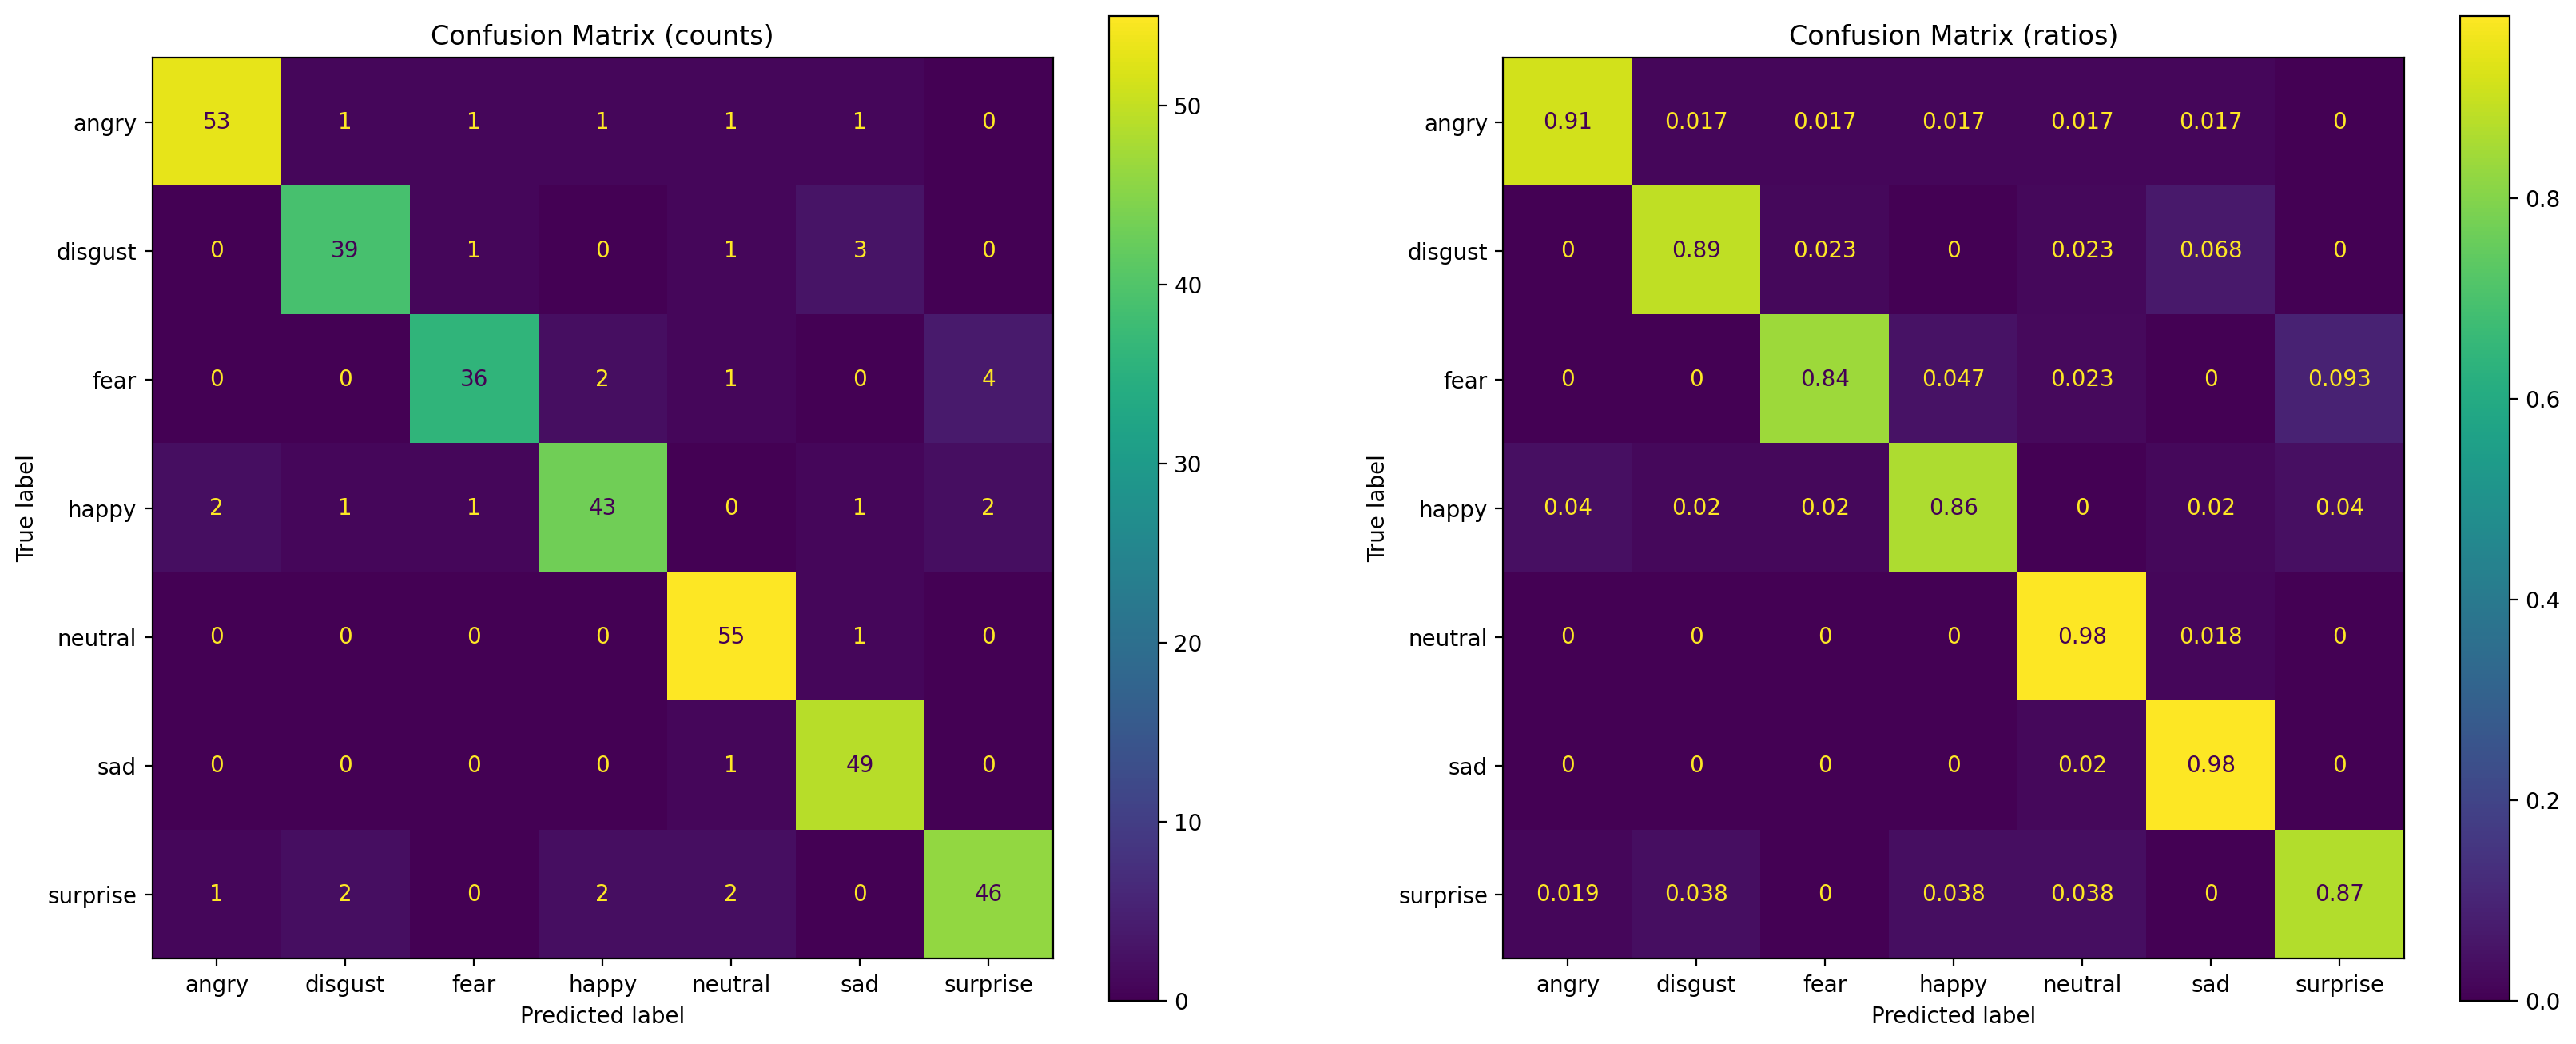

In [ ]:
# Compute test set predictions
predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))

# Plot confusion matrices
plot_confusion_matrices(y_te, pred, name_model, num_exp)